       Bulan                                       Titik_Lokasi    Kecamatan  \
28         1                Kali / Sungai Ciliwung Ruas Veteran       Gambir   
72         1  Kali / Sungai Ciliwung Emplasement PA Manggara...      Menteng   
103        1    Kali / Sungai Ciragil Jembatan Hotel Park Royal  Tanah Abang   
111        1                                    PHB Abdul Jalil  Tanah Abang   
112        1                                   PHB Kampung Bali  Tanah Abang   
...      ...                                                ...          ...   
54106      1                                          PHB Gardu  Kramat Jati   
54130      1                                  PHB Cipinang Jaya   Jatinegara   
54136      1                                       PHB SMAN 100   Jatinegara   
54150      1        Kali Baru Timur Cawang Kompor - Kebon Nanas   Jatinegara   
54155      1         Kali Baru Timur Jembatan Hitam-Jl. Bunga I     Matraman   

             Wilayah  Luas(m2)  Tanggal

c:\Python\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:07:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.80
ROC-AUC Score: 0.73

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.98      0.89     12859
           1       0.64      0.13      0.21      3444

    accuracy                           0.80     16303
   macro avg       0.73      0.55      0.55     16303
weighted avg       0.77      0.80      0.74     16303



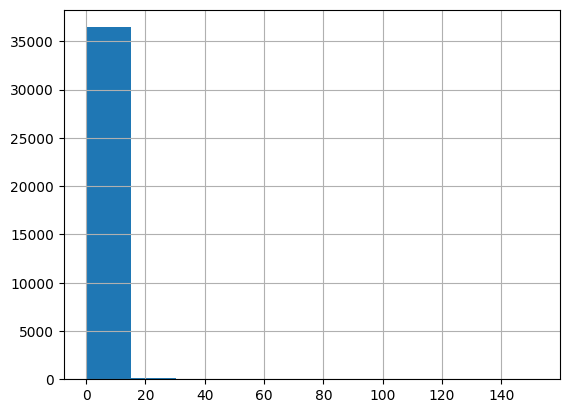

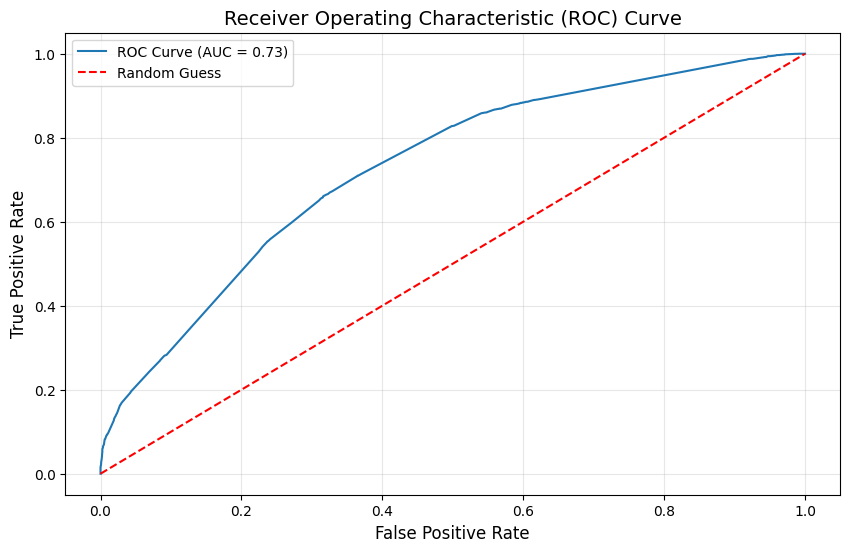

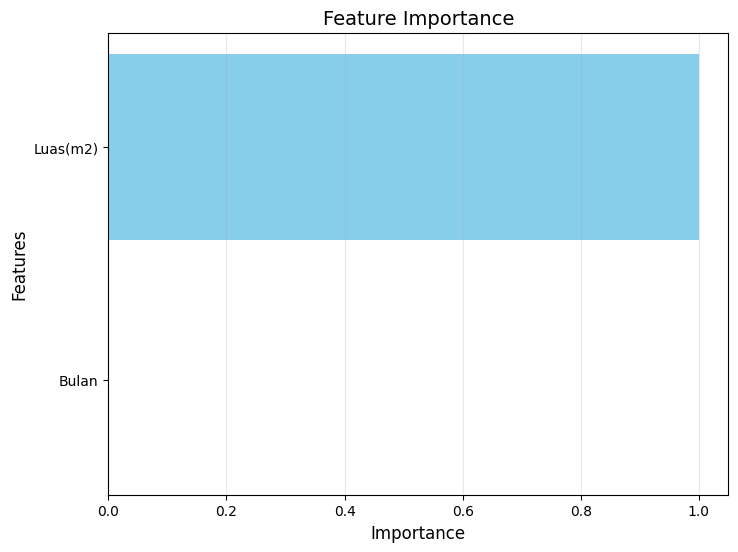

In [18]:
# Import library
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import numpy as np

# Load dataset
file_path = 'Waste-Collection-Volume.csv'  # Replace with your dataset path
df = pd.read_csv(file_path)
# Rename kolom dan merapihkannya (Kode untuk Asumsi 1)
df = df.rename(columns={'bulan':'Bulan', 
                        ' titik_lokasi':'Titik_Lokasi', 
                        ' kecamatan':'Kecamatan', 
                        ' wilayah':'Wilayah', 
                        ' panjang/luas':'Luas(m2)',
                        'satuan_panjang/luas':'Satuan_Panjang_Luas', 
                        'tanggal':'Tanggal', 
                        'volume_sampah_perhari(m3)':'Volume_Sampah_Perhari(m3)'})
# Feature selection (predictors) and target variable
# kode untuk Asumsi 2
df.drop(['Satuan_Panjang_Luas'], axis=1, inplace=True)
df['Luas(m2)'] = pd.to_numeric(df['Luas(m2)'], errors='coerce')  # Mengubah ke float, invalid values jadi NaN
df['Volume_Sampah_Perhari(m3)'] = pd.to_numeric(df['Volume_Sampah_Perhari(m3)'], errors='coerce')  # Mengubah ke float
# Menghitung IQR untuk kolom 'Luas(m2)'
Q1 = df['Luas(m2)'].quantile(0.25)
Q3 = df['Luas(m2)'].quantile(0.75)
IQR = Q3 - Q1

# Mendeteksi outliers
outliers_luas = df[(df['Luas(m2)'] < (Q1 - 1.5 * IQR)) | (df['Luas(m2)'] > (Q3 + 1.5 * IQR))]

print(outliers_luas)

# Menghitung IQR untuk kolom 'Volume_Sampah_Perhari(m3)'
Q1 = df['Volume_Sampah_Perhari(m3)'].quantile(0.25)
Q3 = df['Volume_Sampah_Perhari(m3)'].quantile(0.75)
IQR = Q3 - Q1

# Mendeteksi outliers
outliers_volume = df[(df['Volume_Sampah_Perhari(m3)'] < (Q1 - 1.5 * IQR)) | (df['Volume_Sampah_Perhari(m3)'] > (Q3 + 1.5 * IQR))]

print(outliers_volume)

# Cek ulang
df.isna().sum()
# Melihat perubahan tipe data
df.dtypes

features = ['Bulan', 'Luas(m2)']  # Ganti dengan fitur yang relevan
target = 'Volume_Sampah_Perhari(m3)'  # Target prediksi
df['Volume_Sampah_Perhari(m3)'].hist()

# Convert target variable into binary classification (e.g., above or below mean)
df['Volume_Class'] = (df[target] > df[target].mean()).astype(int)

# Prepare the data
X = df[features]
y = df['Volume_Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the XGBoost Classifier
xgb_classifier = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb_classifier.fit(X_train, y_train)

# Make predictions
y_pred = xgb_classifier.predict(X_test)
y_proba = xgb_classifier.predict_proba(X_test)[:, 1]  # Probability for the positive class

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
classification_rep = classification_report(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_rep)

# Visualize predictions vs actual values (ROC Curve)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Feature importance visualization
importance = xgb_classifier.feature_importances_
plt.figure(figsize=(8, 6))
plt.barh(features, importance, color='skyblue')
plt.title('Feature Importance', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.show()

In [21]:
import joblib
model_filename = 'XGBOOST.pkl'
joblib.dump(xgb_classifier, model_filename)
print(f"Model saved as {model_filename}")

Model saved as XGBOOST.pkl
